# EDA – KoBART 기반 Dialogue Summarization

이 노트북은 **KoBART 백본 실험용** EDA 노트북입니다.
- 데이터 구조 및 길이/turn 분포
- KoBART 토크나이저 기준 토큰 길이 분포
- train/dev vs KoBART prediction 길이 분포 비교
- 요약 스타일(키워드) 확인


## 1. 데이터 로딩

- notebooks/ 폴더에서 실행해도 항상 프로젝트 루트의 `data/`를 바라보도록 경로를 처리합니다.

In [1]:
# 데이터 로딩 셀입니다.
# - 이 노트북이 어디에서 실행되든 프로젝트 루트(nlp_contest)/data 를 기준으로 CSV를 읽습니다.
import pandas as pd
from pathlib import Path

NOTEBOOK_DIR = Path().resolve()
ROOT_DIR = NOTEBOOK_DIR.parent  # nlp_contest/
DATA_DIR = ROOT_DIR / "data"

TRAIN_PATH = DATA_DIR / "train.csv"
DEV_PATH = DATA_DIR / "dev.csv"
TEST_PATH = DATA_DIR / "test.csv"

missing = [p for p in [TRAIN_PATH, DEV_PATH, TEST_PATH] if not p.exists()]
if missing:
    missing_str = ", ".join(str(p) for p in missing)
    raise FileNotFoundError(
        f"다음 파일을 찾을 수 없습니다: {missing_str}\n"
        "- 프로젝트 루트(nlp_contest) 아래 data/에 csv를 넣은 뒤 이 셀을 다시 실행하세요."
    )

train_df = pd.read_csv(TRAIN_PATH)
dev_df = pd.read_csv(DEV_PATH)
test_df = pd.read_csv(TEST_PATH)

train_df.head(), dev_df.head(), test_df.head()

(     fname                                           dialogue  \
 0  train_0  #Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다...   
 1  train_1  #Person1#: 안녕하세요, Mrs. Parker. 잘 지내셨나요?\n#Pers...   
 2  train_2  #Person1#: 저기요, 열쇠 세트 본 적 있어요?\n#Person2#: 어떤 ...   
 3  train_3  #Person1#: 너 여자친구 있는 거 왜 말 안 했어?\n#Person2#: 미...   
 4  train_4  #Person1#: 안녕, 오늘 너무 멋져 보이네요. 저랑 춤 한 곡 추실래요?\n...   
 
                                              summary      topic  
 0  Mr. Smith는 Dr. Hawkins에게 건강검진을 받으러 와서, 매년 검진 필...       건강검진  
 1  Mrs. Parker가 Ricky와 함께 백신 접종을 위해 방문하였고, Dr. Pe...      백신 접종  
 2  #Person1#은 열쇠 세트를 잃어버리고 #Person2#에게 찾는 것을 도와달라...      열쇠 분실  
 3  #Person1#은 #Person2#가 여자친구가 있고 결혼할 예정이라는 사실을 말...  여자친구와의 결혼  
 4  Malik은 Wen과 Nikki에게 춤을 제안하고, Wen은 발을 밟는 것을 감수하...       춤 제안  ,
    fname                                           dialogue  \
 0  dev_0  #Person1#: 안녕하세요, 오늘 기분이 어떠세요?\n#Person2#: 요즘 ...   
 1  dev_1  #Person1#: 야 Jimmy, 오늘 좀 이따 운동하러 가자.\n#Person2...   
 2  dev

## 2. 기본 통계 및 길이/turn 분포

- 전체 크기, 컬럼, 길이/turn 분포를 KoBART 실험 관점에서 확인합니다.

In [2]:
# 데이터 크기, 컬럼, topic 분포를 간단히 확인하는 셀입니다.
print("Train shape:", train_df.shape)
print("Dev shape:", dev_df.shape)
print("Test shape:", test_df.shape)

print("\nTrain columns:", train_df.columns.tolist())
print("Dev columns:", dev_df.columns.tolist())
print("Test columns:", test_df.columns.tolist())

print("\nTrain topic value_counts:\n", train_df.get("topic", pd.Series()).value_counts().head())
print("\nDev topic value_counts:\n", dev_df.get("topic", pd.Series()).value_counts().head())

Train shape: (12457, 4)
Dev shape: (499, 4)
Test shape: (499, 2)

Train columns: ['fname', 'dialogue', 'summary', 'topic']
Dev columns: ['fname', 'dialogue', 'summary', 'topic']
Test columns: ['fname', 'dialogue']

Train topic value_counts:
 topic
음식 주문     130
취업 면접     109
길 안내       66
호텔 체크인     40
아파트 임대     30
Name: count, dtype: int64

Dev topic value_counts:
 topic
호텔 방 예약    5
길 안내       4
취업 면접      4
음식 주문      4
신발 구매      2
Name: count, dtype: int64


In [3]:
# 길이(문자 기준)와 turn 수를 계산하는 셀입니다.
import re

for split_name, df in [("train", train_df), ("dev", dev_df), ("test", test_df)]:
    df["dialogue_len_char"] = df["dialogue"].astype(str).str.len()
    if "summary" in df.columns:
        df["summary_len_char"] = df["summary"].astype(str).str.len()

def count_turns(text: str) -> int:
    return len(re.findall(r"#Person[0-9]+#", str(text)))

train_df["num_turns"] = train_df["dialogue"].apply(count_turns)
dev_df["num_turns"] = dev_df["dialogue"].apply(count_turns)
test_df["num_turns"] = test_df["dialogue"].apply(count_turns)

print("[TRAIN] dialogue_len_char describe:\n", train_df["dialogue_len_char"].describe())
print("[DEV]   dialogue_len_char describe:\n", dev_df["dialogue_len_char"].describe())
print("[TEST]  dialogue_len_char describe:\n", test_df["dialogue_len_char"].describe())

print("\n[TRAIN] num_turns describe:\n", train_df["num_turns"].describe())
print("[DEV]   num_turns describe:\n", dev_df["num_turns"].describe())
print("[TEST]  num_turns describe:\n", test_df["num_turns"].describe())


[TRAIN] dialogue_len_char describe:
 count    12457.000000
mean       406.083487
std        197.566083
min         84.000000
25%        280.000000
50%        369.000000
75%        500.000000
max       2165.000000
Name: dialogue_len_char, dtype: float64
[DEV]   dialogue_len_char describe:
 count     499.000000
mean      400.054108
std       186.163807
min       114.000000
25%       273.000000
50%       367.000000
75%       487.000000
max      1269.000000
Name: dialogue_len_char, dtype: float64
[TEST]  dialogue_len_char describe:
 count     499.000000
mean      422.066132
std       218.245122
min       111.000000
25%       280.000000
50%       386.000000
75%       528.500000
max      2275.000000
Name: dialogue_len_char, dtype: float64

[TRAIN] num_turns describe:
 count    12457.000000
mean         9.491451
std          4.146670
min          2.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         59.000000
Name: num_turns, dtype: float64
[DEV]   num_turns d

## 3.1 대화 길이(문자) 분포 시각화

- train/dev/test의 `dialogue_len_char`를 히스토그램+KDE로 비교합니다.
- encoder 길이 설정 전, 실제 문자 길이 분포를 직관적으로 확인하기 위함입니다.


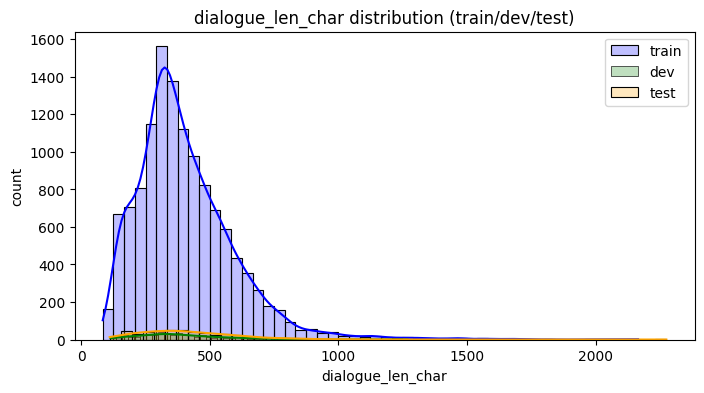

In [4]:
# dialogue_len_char 분포 시각화 (train/dev/test)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
for label, df, color in zip(["train","dev","test"], [train_df, dev_df, test_df], ["blue","green","orange"]):
    sns.histplot(df["dialogue_len_char"], bins=50, kde=True, label=label, color=color, alpha=0.25)
plt.title("dialogue_len_char distribution (train/dev/test)")
plt.xlabel("dialogue_len_char")
plt.ylabel("count")
plt.legend()
plt.show()


## 3.2 turn 수 분포 시각화

- `num_turns`를 train/dev/test별로 비교합니다.
- 대화 교대 횟수가 어느 정도인지 확인해 입력 길이/스타일 판단에 활용합니다.


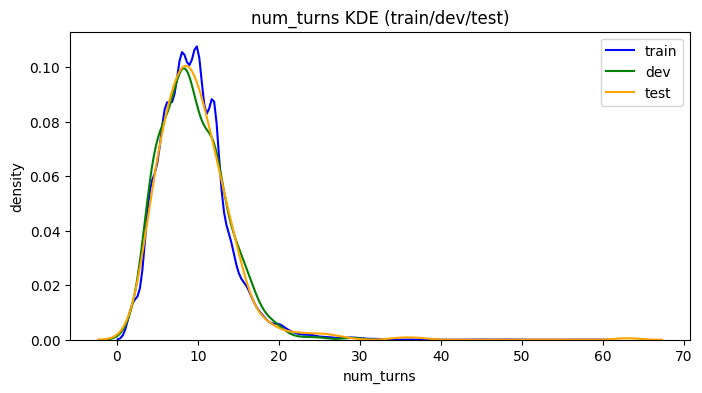

/tmp/ipykernel_274969/1652266870.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=stacked, x="split", y="num_turns", inner="box", palette=["blue","green","orange"], cut=0)


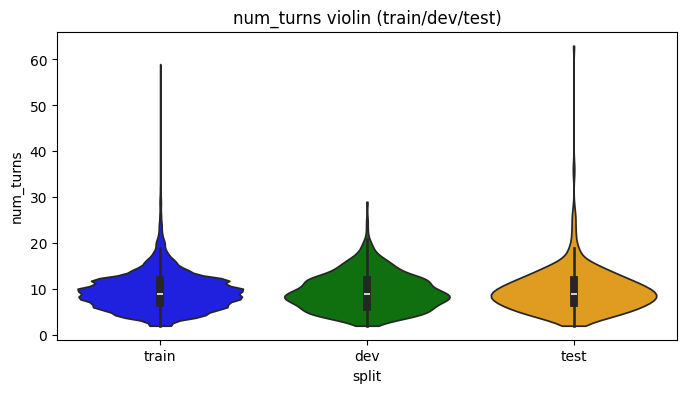

In [5]:
# num_turns 분포 시각화 (train/dev/test)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# KDE만 겹치지 않게 선으로 비교
plt.figure(figsize=(8,4))
for label, df, color in zip(["train","dev","test"], [train_df, dev_df, test_df], ["blue","green","orange"]):
    sns.kdeplot(df["num_turns"], label=label, color=color)
plt.title("num_turns KDE (train/dev/test)")
plt.xlabel("num_turns")
plt.ylabel("density")
plt.legend()
plt.show()

# violin plot로 분포 폭을 비교 (겹침 최소화)
plt.figure(figsize=(8,4))
stacked = pd.concat([
    train_df[["num_turns"]].assign(split="train"),
    dev_df[["num_turns"]].assign(split="dev"),
    test_df[["num_turns"]].assign(split="test"),
])
sns.violinplot(data=stacked, x="split", y="num_turns", inner="box", palette=["blue","green","orange"], cut=0)
plt.title("num_turns violin (train/dev/test)")
plt.xlabel("split")
plt.ylabel("num_turns")
plt.show()


## 3. KoBART 토크나이저 기준 토큰 길이 분포

- KoBART 토크나이저로 dialogue를 토크나이즈했을 때 토큰 길이 분포를 확인합니다.
- encoder_max_len=1024 설정이 얼마나 여유 있는지, 잘리는 비율이 어느 정도인지 보는 것이 목적입니다.
- train/dev/test 모두 확인합니다.


You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.


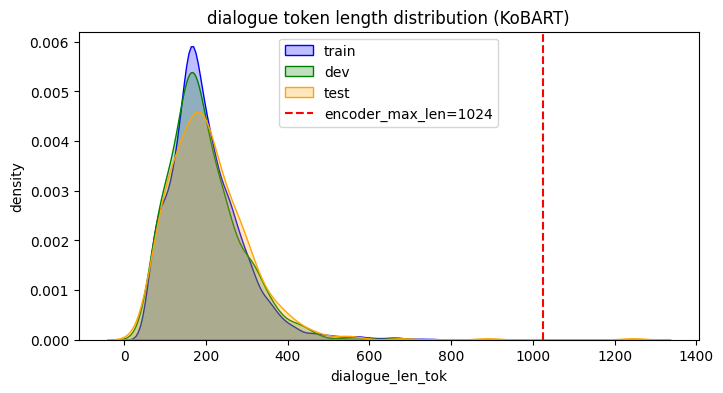

[TRAIN] encoder_max_len=1024 초과 비율: 0.0002
[DEV] encoder_max_len=1024 초과 비율: 0.0000
[TEST] encoder_max_len=1024 초과 비율: 0.0020


In [6]:
# KoBART 토크나이저 기준 토큰 길이 분포를 그리는 셀입니다.
from transformers import PreTrainedTokenizerFast
import matplotlib.pyplot as plt
import seaborn as sns

kobart_tok = PreTrainedTokenizerFast.from_pretrained("gogamza/kobart-base-v1")

def token_len(text: str) -> int:
    return len(kobart_tok.encode(str(text), add_special_tokens=True))

for split_name, df in [("train", train_df), ("dev", dev_df), ("test", test_df)]:
    df["dialogue_len_tok"] = df["dialogue"].apply(token_len)

plt.figure(figsize=(8, 4))
for label, df, color in zip(["train", "dev", "test"], [train_df, dev_df, test_df], ["blue", "green", "orange"]):
    sns.kdeplot(df["dialogue_len_tok"], label=label, fill=True, alpha=0.25, color=color)
plt.axvline(1024, color="red", linestyle="--", label="encoder_max_len=1024")
plt.title("dialogue token length distribution (KoBART)")
plt.xlabel("dialogue_len_tok")
plt.ylabel("density")
plt.legend()
plt.show()

for label, df in [("TRAIN", train_df), ("DEV", dev_df), ("TEST", test_df)]:
    over_rate = (df["dialogue_len_tok"] > 1024).mean()
    print(f"[{label}] encoder_max_len=1024 초과 비율: {over_rate:.4f}")


## 4. train/dev/test 길이 분포 비교 (문자 기준)

- train/dev/test의 대화 길이(문자 기준) 분포를 KDE로 비교합니다.
- test 길이 분포를 함께 보아 inference 시 길이 초과 위험을 가늠합니다.


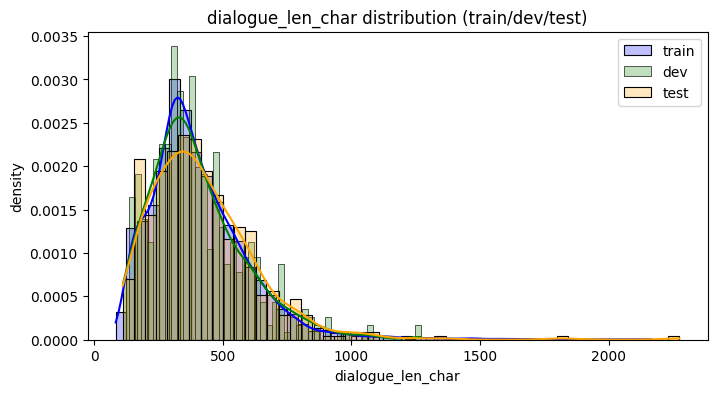

In [7]:
# dialogue_len_char 분포 시각화 (train/dev/test)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
for label, df, color in zip(["train","dev","test"], [train_df, dev_df, test_df], ["blue","green","orange"]):
    sns.histplot(df["dialogue_len_char"], bins=50, kde=True, stat="density", label=label, color=color, alpha=0.25)
plt.title("dialogue_len_char distribution (train/dev/test)")
plt.xlabel("dialogue_len_char")
plt.ylabel("density")
plt.legend()
plt.show()


## 5. KoBART prediction sanity check 및 길이 분포

- 현재 KoBART 실험에서 생성된 prediction CSV를 읽어 형식/길이 분포를 확인합니다.
- 파일 경로는 실제 실험 결과에 맞게 수정해서 사용하세요.


    fname                                            summary
0  test_0  #Person1#은 Ms. Dawson에게 사내 메모를 작성해 달라고 요청합니다. ...
1  test_1  #Person1#과 #Person2#는 출퇴근 시간에 교통체증으로 인한 교통 체증과...
2  test_2  #Person1#은 Kate에게 Masha와 Hero가 두 달 동안 별거 중이며, ...
3  test_3  #Person1#은 Brian의 생일을 축하하기 위해 선물을 준비합니다. #Pers...
4  test_4   #Person1#과 #Person2#는 올림픽 공원의 크기와 시설에 대해 이야기합니다.
rows: 499
fname unique: 499
empty summary 비율: 0.0
summary 길이 통계:
 count    499.000000
mean      81.200401
std       30.351686
min       18.000000
25%       57.500000
50%       79.000000
75%      100.500000
max      172.000000
Name: summary, dtype: float64


/tmp/ipykernel_274969/3344322556.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df["summary_len_char"], label="gold train summary", shade=True)
/tmp/ipykernel_274969/3344322556.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pred_df["summary"].astype(str).str.len(), label="KoBART pred summary", shade=True)


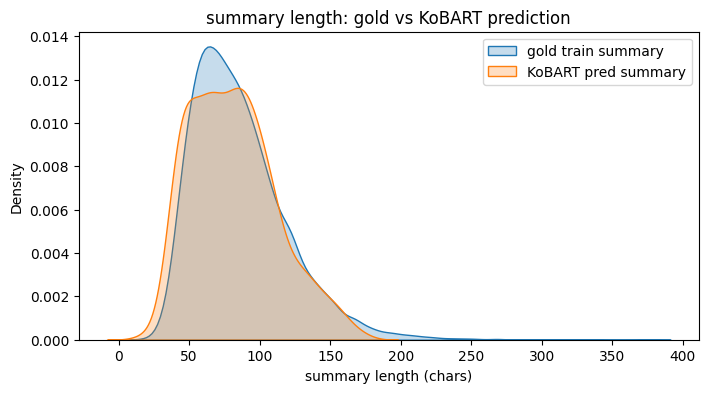

In [8]:
# KoBART prediction CSV를 읽어서 기본 형식과 summary 길이 분포를 확인하는 셀입니다.
PRED_PATH = ROOT_DIR / "prediction" / "2511292249_kobart-base-style_prompt_bs8.csv"  # 필요시 최신 파일로 수정

if not PRED_PATH.exists():
    print(f"prediction 파일을 찾을 수 없습니다: {PRED_PATH}")
else:
    pred_df = pd.read_csv(PRED_PATH)
    print(pred_df.head())
    print("rows:", len(pred_df))
    print("fname unique:", pred_df["fname"].nunique())
    empty_ratio = (pred_df["summary"].astype(str).str.strip() == "").mean()
    print("empty summary 비율:", empty_ratio)
    print("summary 길이 통계:\n", pred_df["summary"].astype(str).str.len().describe())

    plt.figure(figsize=(8, 4))
    sns.kdeplot(train_df["summary_len_char"], label="gold train summary", shade=True)
    sns.kdeplot(pred_df["summary"].astype(str).str.len(), label="KoBART pred summary", shade=True)
    plt.title("summary length: gold vs KoBART prediction")
    plt.xlabel("summary length (chars)")
    plt.legend()
    plt.show()